#### Torchify

In [61]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
words = open('../names.txt', 'r').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [63]:
vocab = sorted(set("".join(words)))
vocab = ['.'] + vocab
vocab_size = len(vocab)
vocab_size, vocab[:5]

(27, ['.', 'a', 'b', 'c', 'd'])

In [64]:
stoi = {s:i for i,s in enumerate(vocab)}
itos = {i:s for s,i in stoi.items()}
stoi

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [ ]:
class Linear:
  def __init__(self, fan_in, fan_out):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out)
  
  def __call__(self, x):
    self.out = x @ self.weight + self.bias
    return self.out
  
  def parameters(self):
    return [self.weight, self.bias]

# TODO below is wrong
class BatchNorm:
  def __init__(self, fan_in, fan_out):
    self.bngain = torch.ones((1,fan_in))
    self.bnbias = torch.zeros((1,fan_in))
    # check why mean are zeros and std are ones
    self.bnmean_running = torch.zeros((1, fan_in))
    self.bnstd_running = torch.ones((1, fan_in))
  
  def __call__(self, x):
    self.bnmeani = x.mean(0, keepdim=True)
    self.bnstdi = x.std(0, keepdim=True)
    # notes: read again, check what happens to the result of hpreact after below operation
    with torch.no_grad():
      self.bnmean_running = 0.999 * self.bnmean_running + 0.001 * self.bnmeani
      self.bnstd_running  = 0.999 * self.bnstd_running  + 0.001 * self.bnstdi

    self.out = self.bngain * ((x - self.bnmeani) / self.bnstdi) + self.bnbias
    return self.out
  
  def parameters(self):
    return [self.bngain, self.bnbias]

In [65]:
# init dataset
g = torch.Generator().manual_seed(821974)
block_size = 6

X,Y=[],[]
for w in words:
  context = [0] * block_size
  for ch in w+'.':
    X.append(context)
    Y.append(stoi[ch])
    context=context[1:] + [stoi[ch]]

X = torch.tensor(X)
Y = torch.tensor(Y)

print(X.shape, Y.shape)

n_embd = 10
n_hidden = 100
C  = torch.randn((vocab_size, n_embd)          , generator=g)
W1 = torch.randn((block_size*n_embd, n_hidden) , generator=g)  * ((5/3)/((block_size*n_embd)**0.5))
b1 = torch.randn(n_hidden                      , generator=g)  * 0.001
W2 = torch.randn((n_hidden, vocab_size)        , generator=g)  * 0.01
b2 = torch.randn(vocab_size                    , generator=g)  * 0.001

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

# check why mean are zeros and std are ones
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C,W1,b1,W2,b2, bngain, bnbias]
for p in parameters:
  p.requires_grad = True


torch.Size([228146, 6]) torch.Size([228146])


In [66]:
lr = 0.1
steps = 100_000
decay_steps = 10_000
decay_factor = 10
batch_size = 64 

lossi = []

for i in range(steps+decay_steps):
  # forward pass
  batch = torch.randint(0, X.shape[0], (batch_size, ), generator=g)
  emb = C[X[batch]]
  hpreact = emb.view(-1, block_size*n_embd) @ W1 + b1
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  # notes: read again, check what happens to the result of hpreact after below operation
  hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[batch])
  lossi.append(loss.item())

  # reset grads
  for p in parameters:
    p.grad = None
  # recompute
  loss.backward()
  # update
  lri = lr if i < steps else lr/decay_factor
  for p in parameters:
    p.data += -lri * p.grad

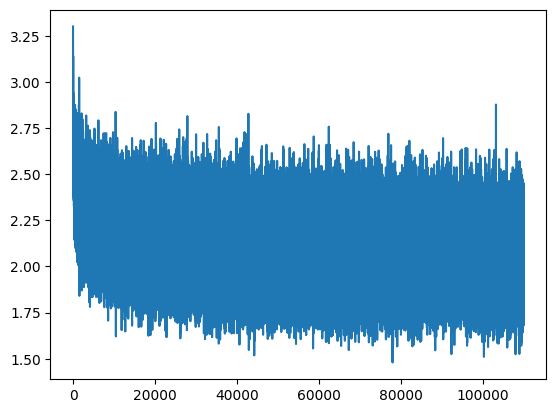

In [67]:
plt.plot(lossi)

In [68]:
# inference
for _ in range(5):
  context = [0] * block_size
  out=[]
  while True:
    emb = C[context]
    hpreact = emb.view(-1, block_size*n_embd) @ W1 + b1
    hpreact = ((hpreact - bnmean_running) / bnstd_running)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    hit = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    out.append(hit)
    if hit == 0:
      break
    context=context[1:]+[hit]
  print(''.join(itos[o] for o in out))

veeima.
mazerel.
erdyabensle.
chemelth.
zophangstisanceani.
